In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import seaborn as sns
import cv2
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

Test Basic Models on Binary Dataset + Make overall ROC/AUC

Data Preparation

In [2]:
normal_X = pickle.load(open('pickled_data/normal.pkl', "rb" ))
covid_X = pickle.load(open('pickled_data/covid.pkl', "rb" ))
NUM_NORMAL = len(normal_X)
NUM_COVID = len(covid_X)
BINARY_LIST = ['Normal', 'COVID']

X = np.concatenate([normal_X, covid_X], axis=0)
X = X.reshape((X.shape[0], -1))
y = np.array([0] * NUM_NORMAL + [1] * NUM_COVID)

Data Visualization

PCA to compare normal data from different sources, t-SNE from sklearn, PCA then t-SNE

Source: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [5]:
principalComponents = PCA(n_components=2).fit_transform(X)
tSNEComponents = TSNE(n_components=2).fit_transform(X)
PC_tSNEComponents = TSNE(n_components=2).fit_transform(PCA(n_components=50).fit_transform(X))

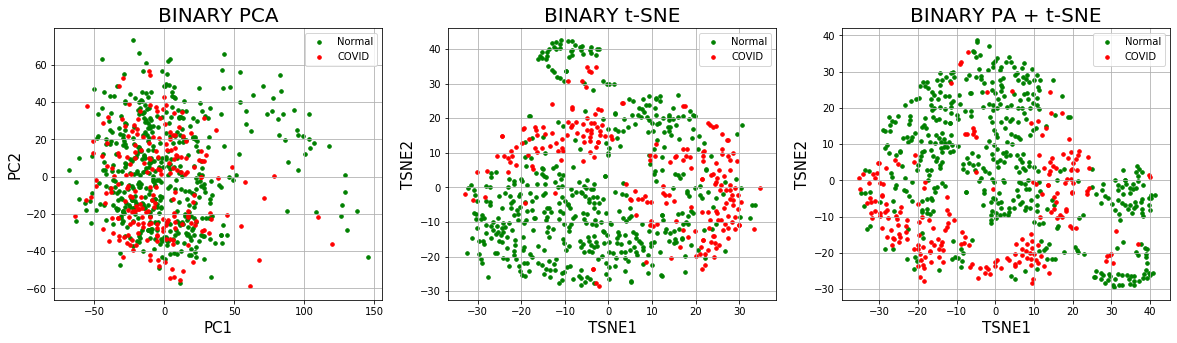

In [6]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
labels = list(map(lambda i:BINARY_LIST[i], y))
principalDf['target'] = labels

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('BINARY PCA', fontsize = 20)
targets = BINARY_LIST
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'PC1']
               , principalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50
               , marker = '.')
ax.legend(targets)
ax.grid()

principalDf = pd.DataFrame(data = tSNEComponents, columns = ['TSNE1', 'TSNE2'])
labels = list(map(lambda i:BINARY_LIST[i], y))
principalDf['target'] = labels

ax = fig.add_subplot(1,3,2) 
ax.set_xlabel('TSNE1', fontsize = 15)
ax.set_ylabel('TSNE2', fontsize = 15)
ax.set_title('BINARY t-SNE', fontsize = 20)
targets = BINARY_LIST
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'TSNE1']
               , principalDf.loc[indicesToKeep, 'TSNE2']
               , c = color
               , s = 50
               , marker = '.')
ax.legend(targets)
ax.grid()

principalDf = pd.DataFrame(data = PC_tSNEComponents, columns = ['TSNE1', 'TSNE2'])
labels = list(map(lambda i:BINARY_LIST[i], y))
principalDf['target'] = labels

ax = fig.add_subplot(1,3,3) 
ax.set_xlabel('TSNE1', fontsize = 15)
ax.set_ylabel('TSNE2', fontsize = 15)
ax.set_title('BINARY PA + t-SNE', fontsize = 20)
targets = BINARY_LIST
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'TSNE1']
               , principalDf.loc[indicesToKeep, 'TSNE2']
               , c = color
               , s = 50
               , marker = '.')
ax.legend(targets, loc='upper right')
ax.grid()

Train Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression

In [4]:
clf = LogisticRegression(class_weight='balanced', max_iter=100)

In [10]:
# First need to cross validate model
cv_results = cross_validate(clf, X, y, cv=5)
print('CV: {}'.format(np.mean(cv_results['test_score'])))

CV: 0.7988386433710175


In [5]:
# Gather statistics about logistic regression
lr = clf.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       104
           1       0.70      0.86      0.78        36

    accuracy                           0.87       140
   macro avg       0.83      0.87      0.84       140
weighted avg       0.89      0.87      0.88       140



Visualize the weights of logistic regression and overlay them with actual images

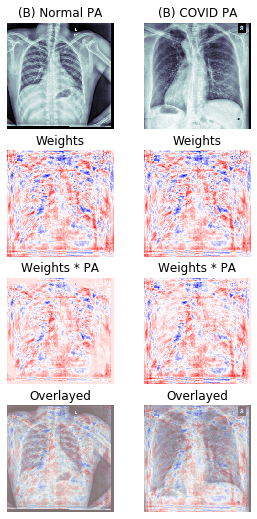

In [18]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(4.5,9), sharey=True, sharex=True)
[axi.set_axis_off() for axi in ax.ravel()]

img1, img2 = pickle.load(open('pickled_data/test.pkl', "rb" ))[:2]
images = [img1, img2]
for i in range(2):
    weights = lr.coef_.reshape((224, 224, 3))
    ax[1, i].imshow(weights[:, :, 0], cmap="bwr")
    ax[1, i].set_title('Weights')
    
    real_image = images[i].reshape((224, 224, 3))[:, :, 0]
    ax[2, i].imshow(weights[:, :, 0]*real_image, cmap="bwr")
    ax[2, i].set_title('Weights * PA')
    
    ax[0, i].imshow(real_image, cmap=plt.cm.bone)
    ax[0, i].set_title('(B) {} PA'.format(BINARY_LIST[i]))
    
    ax[3, i].imshow(weights[:, :, 0] * real_image, cmap="bwr")
    ax[3, i].imshow(real_image, cmap=plt.cm.bone, alpha=.5)
    ax[3, i].set_title('Overlayed')

    

k-Nearest Neighbors

In [6]:
knn = KNeighborsClassifier(weights='distance')
cv_results = cross_validate(knn, X, y, cv=5)
print('CV: {}'.format(np.mean(cv_results['test_score'])))

CV: 0.7786742034943475


In [9]:
y_pred = knn.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.90       104
           1       0.69      0.86      0.77        36

    accuracy                           0.86       140
   macro avg       0.82      0.86      0.83       140
weighted avg       0.88      0.86      0.87       140



Load neural network models to make predictions on the test split

In [26]:
os.listdir('best_model')

['best_resnetV2152.hdf5',
 'best_densenet169.hdf5',
 'best_densenet201.hdf5',
 'best_vgg16.hdf5',
 'best_densenet121.hdf5',
 'best_vgg.hdf5',
 'best_vgg19.hdf5',
 'best_resnetV2101.hdf5',
 'best_resnetV250.hdf5']

In [7]:
densenet = load_model('best_model/best_densenet169.hdf5')
vgg =  load_model('best_model/best_vgg16.hdf5')
resnet =  load_model('best_model/best_resnetV2101.hdf5')

In [10]:
# keep probabilities for the positive outcome only
ns_probs = np.zeros(len(X_test))
knn_probs = knn.predict_proba(X_test)[:, 1]
lr_probs = lr.predict_proba(X_test)[:, 1]
densenet_probs = densenet.predict(X_test.reshape((140,224,224,3)))[:, 0]
vgg_probs = vgg.predict(X_test.reshape((140,224,224,3)))[:, 0]
resnet_probs = resnet.predict(X_test.reshape((140,224,224,3)))[:, 0]

Make ROC and Precision Recall Curve

Reference: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

Logistic Regression: ROC AUC=0.9488514957264957
k-Nearest Neighbor: ROC AUC=0.9244123931623931
DenseNet: ROC AUC=0.9903846153846154
VGG: ROC AUC=0.9642094017094017
ResNet: ROC AUC=0.9594017094017093


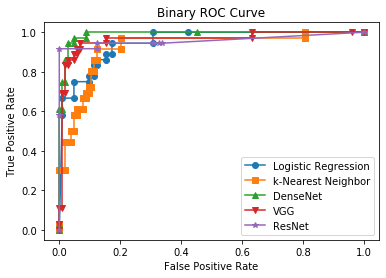

In [11]:
models = ['Logistic Regression', 'k-Nearest Neighbor', 'DenseNet', 'VGG', 'ResNet']
probs = [knn_probs, lr_probs, densenet_probs, vgg_probs, resnet_probs]
markers = ['o', 's', '^', 'v', '*']

for i in range(len(models)):
    auc_roc = roc_auc_score(y_test, probs[i])
    print('{}: ROC AUC={}'.format(models[i], auc_roc))
    fpr, tpr, _ = roc_curve(y_test, probs[i])
    plt.plot(fpr, tpr, marker=markers[i], label=models[i])
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary ROC Curve')
plt.legend()
plt.axis('on')
plt.show()


Logistic Regression AUC : 0.8820331705141217
k-Nearest Neighbor AUC : 0.8220864647922985
DenseNet AUC : 0.971171911163831
VGG AUC : 0.9023843092023618
ResNet AUC : 0.9575081738934652


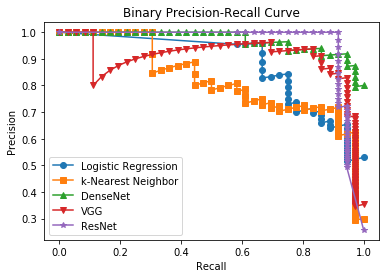

In [12]:
for i in range(len(models)):
    precision, recall, _ = precision_recall_curve(y_test, probs[i])
    area = auc(recall, precision)
    print('{} AUC : {}'.format(models[i], area))
    plt.plot(recall, precision, marker=markers[i], label=models[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Binary Precision-Recall Curve')
plt.legend()
plt.show()
